### Data Importation
Using two threads running in parallel one parsing the reviews json file extracting product reviews and the other one parsing the product metadata json file to build full observations. 

In [6]:
import threading 
import time 
import pandas as pd 

#Function that parses reviews data from json file
def _extract_reviews(path_name,reviews,reviews_lock,products,products_lock,queued,queued_lock,merged_data,merged_data_lock):
    
    with open(path_name, 'r') as file:
        
        previous_asin = 'alpha'
        
        for line in file:
            if len(merged_data) <  650000:
                #evaluating an observation that is in json would convert it to a dictionary in python
                review_dict = eval(line)
                #Extracting the unique identifier for each movie/tv shows title
                asin = review_dict.get('asin')
                
                #if asin is missing for a title , dump that data and keep parsing 
                if asin == None:
                    del line 
                    del review_dict
                    del asin 
                    continue 
                #if the asin for the observation already exists as a key in the reviews dictionary
                #simply append the dictionary for that observation in the list associated with the asin key
                if asin in reviews:
                    with reviews_lock:
                        reviews[asin].append( review_dict )
                #if asin doesn't exist as a key, make a new one and associate a list to it with the observation dict        
                else:
                    with reviews_lock:
                        reviews[asin] = [ review_dict ] 
                        
                #This means we've moved on to the reviews for the next product due to how all the
                #reviews are structured in the json file
                if previous_asin != asin:
                    #Check if product thread has found the metada for that title while parsing the product data file
                    if previous_asin in products:
                        
                        product_metadata = products.get( previous_asin )
                        
                        with products_lock:
                            del products[previous_asin]
                        
                        for review in reviews[previous_asin]:
                            full_review_dict = _build_full_review_dict( review, product_metadata )
                            with merged_data_lock:
                                merged_data.append( full_review_dict )
                            del review
                            del full_review_dict
                            
                        with reviews_lock:
                            del reviews[previous_asin]
                        
                        del product_metadata
                    #If not then simply add that product asin to the queued dictionary to be parsed when product asin is found     
                    else:
                        
                        with queued_lock:
                            queued.add( previous_asin )
                            
                            
                previous_asin = asin
                #clean up memory
                del line 
                del review_dict
                
            else:
                break 
                        
                
#Function that parses products metadata from json file
def _extract_product_meta(path_name,reviews,reviews_lock,products,products_lock,queued,queued_lock,merged_data,merged_data_lock):
    
    with open(path_name, 'r') as file:
        
        for line in file:
            #Limiting total data to 650,000 observations 
            if len(merged_data) < 650000:
                product_dict = eval(line)
                
                asin = product_dict.get('asin')
                if asin == None or product_dict.get('title') == None:
                    del line 
                    del product_dict
                    del asin 
                    continue 
                    
                categories = product_dict.get('categories')
                #Checking product categories exist and are 'movies' or 'tv' or 'movies & tv'
                if categories != None:
                    
                    sanitized_categories = [ c.lower() for c in categories[0] ]
                    
                    if 'movies' not in sanitized_categories and \
                    'tv' not in sanitized_categories and \
                    'movies & tv' not in sanitized_categories:
                        del line 
                        del product_dict
                        del asin 
                        del categories 
                        del sanitized_categories
                        continue 
                    else:
                        del categories 
                        del sanitized_categories 
                #If the reviews for the product have already been parsed awaiting metada , extract and build a full observation 
                #with product reviews and title 
                if asin in queued:
                    with queued_lock:
                        queued.remove(asin)
                        
                    for review in reviews[asin]:
                        full_review_dict = _build_full_review_dict( review, product_dict )
                        
                        with merged_data_lock:
                            merged_data.append(full_review_dict)
                            
                        del review 
                        del full_review_dict
                            
                    with reviews_lock:
                        del reviews[asin]
                        
                #If the reviews for this product have not been parsed , put the unique identifier for this product in
                #the product dictionary which will be extracted when they are parsed by the review thread 
                else:
                    with products_lock:
                        products[asin] = { 'title': product_dict.get('title') }
                        
                #clean up memory        
                del line 
                del product_dict
                del asin 
                
            else:
                break
                
#Given the observations as two deparate dicitonaries, combines them into one using relevant information                 
def _build_full_review_dict( review_dict, product_meta_dict ):
    full = {}
    full['reviewerID'] = review_dict.get('reviewerID')
    full['asin'] = review_dict.get('asin')
    full['reviewerName'] = review_dict.get('reviewerName')
    full['helpful'] = review_dict.get('helpful')
    full['reviewText'] = review_dict.get('reviewText')
    full['overall'] = review_dict.get('overall')
    full['summary'] = review_dict.get('summary')
    full['title'] = product_meta_dict.get('title')
    return full 


reviews = {}
reviews_lock = threading.Lock()

products = {}
products_lock = threading.Lock()

queued = set()
queued_lock = threading.Lock()

merged_data = []
merged_data_lock = threading.Lock()

#Initialize thread that will parse reviews 
reviews_thread = threading.Thread( target = _extract_reviews , 
                                 args = ( '/Users/sam/DataScience/Datasets/reviews_Movies_and_TV_5.json', 
                                        reviews,reviews_lock,products,products_lock,queued,queued_lock,merged_data,merged_data_lock) 
                                 )
#Initialize thread that will parse products 
products_thread = threading.Thread( target = _extract_product_meta , 
                                 args = ( '/Users/sam/DataScience/Datasets/metadata.json', 
                                        reviews,reviews_lock,products,products_lock,queued,queued_lock,merged_data,merged_data_lock) 
                                 )

#Start timer 
start = time.time()
#Start threads
reviews_thread.start()
products_thread.start()
#Momentarily print progress report to the console 
counter = 0
while reviews_thread.isAlive() or products_thread.isAlive():
    if counter % 3000000 == 0:
        print ('Reviews left in reviews dict: ' + str(len(reviews)) + ', Products sitting in products dict: ' + str(len(products)) + ', Total data merged: ' + str(len(merged_data)))
        counter += 1
        pass
    else:
        counter += 1
        pass
    
#Calculate time threads are done running 
end = time.time()
#Print final report including total time elapsed 
print('Reviews remaining in reviews dict: ' + str(len(reviews)))
print('Irrelevant products sitting in products dict: ' + str(len(products)))
print('Total relevant reviews merged with the products metadata: ' + str(len(merged_data)))
print('\nExample of a full observation: ' + str(merged_data[0]) + '\n')


time_elapsed = end - start

print('Total time elapsed: ' + str(time_elapsed) + ' seconds')    

Reviews left in reviews dict: 0, Products sitting in products dict: 0, Total data merged: 0
Reviews left in reviews dict: 74, Products sitting in products dict: 47, Total data merged: 201
Reviews left in reviews dict: 144, Products sitting in products dict: 47, Total data merged: 201
Reviews left in reviews dict: 210, Products sitting in products dict: 47, Total data merged: 201
Reviews left in reviews dict: 292, Products sitting in products dict: 47, Total data merged: 201
Reviews left in reviews dict: 419, Products sitting in products dict: 47, Total data merged: 201
Reviews left in reviews dict: 526, Products sitting in products dict: 47, Total data merged: 201
Reviews left in reviews dict: 592, Products sitting in products dict: 47, Total data merged: 201
Reviews left in reviews dict: 644, Products sitting in products dict: 54, Total data merged: 201
Reviews left in reviews dict: 732, Products sitting in products dict: 60, Total data merged: 201
Reviews left in reviews dict: 785, P

In [ ]:
#Clean up
del reviews, products, queued
#Convert to pandas df
data = pd.DataFrame(merged_data)
#Save data to csv file on hard disk 
data.to_csv('/Users/sam/DataScience/Datasets/amazon_movies_and_tv_reviews.csv')
#Clean up
del merged_data

In [2]:
#Loading the data from the csv file 
import pandas as pd 
data = pd.read_csv('amazon_movies_and_tv_reviewsM.csv')

//anaconda3/envs/nlp_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

Unnamed: 0      reviewerID        asin                     reviewerName  \
0           0   AH3QC2PC1VTGP  0000143561                  Great Home Cook   
1           1  A1CV1WROP5KTTW  0000589012  Alberta M. Worth "BertieMWorth"   
2           2   AP57WZ2X4G0AA  0000589012                Amy Arnett-German   
3           3  A3NMBJ2LCRCATT  0000589012                Carole J. Hopkins   
4           4   A5Y15SAOMX6XA  0000589012             Catherine E. Wetzler   

    helpful                                         reviewText  overall  \
0    [2, 4]  I have to admit that I am a fan of Giada's coo...      2.0   
1    [2, 2]  I have read many books and literature written ...      5.0   
2    [0, 1]  The information is good, but the presentation ...      2.0   
3    [1, 1]  I have read the original Why Don't They Just Q...      5.0   
4  [12, 16]  I, too, purchased this to use with my patients...      2.0   

                                             summary  \
0                             Don't waste your money   
1  "Why Don't They Just Qiut" DVD Roundtable Disc...   
2                                             Boring   
3                                       Very helpful   
4                                         C+ At Best   

                                               title  
0  Everyday Italian (with Giada de Laurentiis), V...  
1  Why Don't They Just Quit? DVD Roundtable Discu...  
2  Why Don't They Just Quit? DVD Roundtable Discu...  
3  Why Don't They Just Quit? DVD Roundtable Discu...  
4  Why Don't They Just Quit? DVD Roundtable Discu...

In [4]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046027 entries, 0 to 1048589
Data columns (total 9 columns):
Unnamed: 0      1046027 non-null int64
reviewerID      1046027 non-null object
asin            1046027 non-null object
reviewerName    1046027 non-null object
helpful         1046027 non-null object
reviewText      1046027 non-null object
overall         1046027 non-null float64
summary         1046027 non-null object
title           1046027 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 79.8+ MB


In [5]:
print( 'Total reviews:' , len(data)  )
print( 'Number of T.V. shows and Movies reviewed:' , len(data.asin.unique()) )
print('Total number of reviewers:', len(data.reviewerID.unique()) )

Total reviews: 1046027
Number of T.V. shows and Movies reviewed: 28635
Total number of reviewers: 575872


### Data Visualization

#### Visualizing ratings distribution in the data

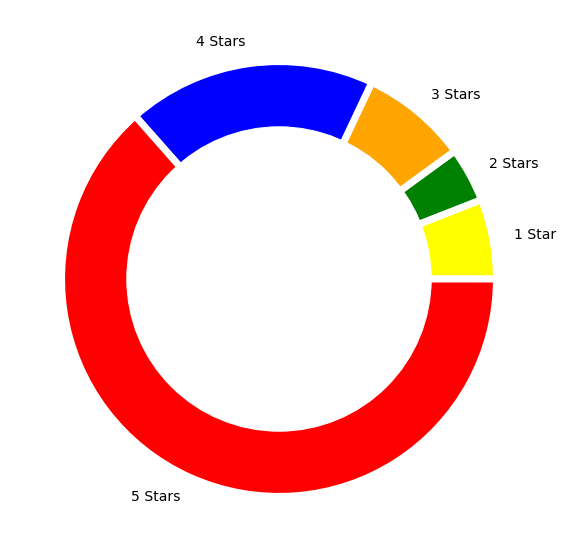

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns 
#Group dataframe by rating 
ratings_distribution = data[['asin','overall']] \
.groupby('overall') \
.count() \
.reset_index() \
.rename( columns = {'asin':'count'} )
#visualize distributions using a doughnut plot 
f,ax = plt.subplots( figsize = (10,10) )
names =  [ '1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars' ]
size = list( ratings_distribution['count'] )
my_circle = plt.Circle( (0,0), 0.7, color = 'white' )
plt.pie( size, labels = names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=['yellow','green','orange','blue', 'red'],
       textprops={'fontsize': 14})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

* Looking at the doughnut chart we can see that 5 star reviews account for 63% of all reviews and 1 star reviews account for the smallest chunk which could be intepreted as people mostly only review a product when they are very satisified with it.
* I would have also thought that people mostly also leave a review when they are extremely unsatisfied with a product as well but according to the data that does not seem to be the case.

In [8]:
#Combining review text and summary columns into one column called 'review_text
data['review_text'] = data['reviewText'] + ' . ' + data['summary']
del data['reviewText']
del data['summary']
data.head()

Unnamed: 0      reviewerID        asin                     reviewerName  \
0           0   AH3QC2PC1VTGP  0000143561                  Great Home Cook   
1           1  A1CV1WROP5KTTW  0000589012  Alberta M. Worth "BertieMWorth"   
2           2   AP57WZ2X4G0AA  0000589012                Amy Arnett-German   
3           3  A3NMBJ2LCRCATT  0000589012                Carole J. Hopkins   
4           4   A5Y15SAOMX6XA  0000589012             Catherine E. Wetzler   

    helpful  overall                                              title  \
0    [2, 4]      2.0  Everyday Italian (with Giada de Laurentiis), V...   
1    [2, 2]      5.0  Why Don't They Just Quit? DVD Roundtable Discu...   
2    [0, 1]      2.0  Why Don't They Just Quit? DVD Roundtable Discu...   
3    [1, 1]      5.0  Why Don't They Just Quit? DVD Roundtable Discu...   
4  [12, 16]      2.0  Why Don't They Just Quit? DVD Roundtable Discu...   

                                         review_text  
0  I have to admit that I am a fan of Giada's coo...  
1  I have read many books and literature written ...  
2  The information is good, but the presentation ...  
3  I have read the original Why Don't They Just Q...  
4  I, too, purchased this to use with my patients...

#### Visualizing character distribution in review text by rating score

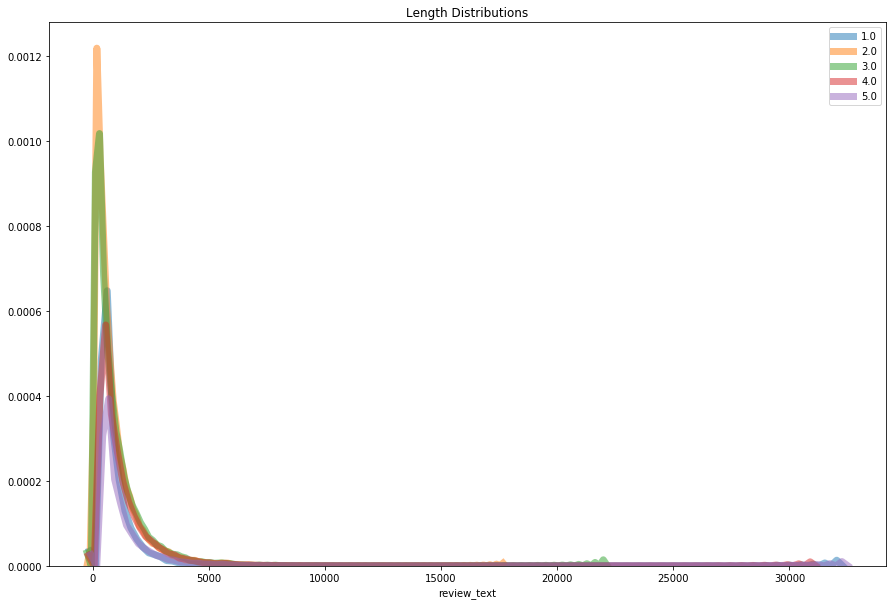

In [9]:
f,ax = plt.subplots( figsize = (15,10) )
r_one = data[ data['overall'] == 1.0 ]['review_text'].str.len()
sns.distplot(r_one, hist = False, kde_kws = {'linewidth':7, 'alpha':0.5}, label = '1.0')
r_two = data[ data['overall'] == 2.0 ]['review_text'].str.len()
sns.distplot(r_two, hist = False, kde_kws = {'linewidth':7, 'alpha':0.5}, label = '2.0')
r_three = data[ data['overall'] == 3.0 ]['review_text'].str.len()
sns.distplot(r_three, hist = False, kde_kws = {'linewidth':7, 'alpha':0.5}, label = '3.0')
r_four = data[ data['overall'] == 4.0 ]['review_text'].str.len()
sns.distplot(r_four, hist = False, kde_kws = {'linewidth':7, 'alpha':0.5}, label = '4.0')
r_five = data[ data['overall'] == 5.0 ]['review_text'].str.len()
sns.distplot(r_five, hist = False, kde_kws = {'linewidth':7, 'alpha':0.5}, label = '5.0')
plt.title('Length Distributions')
plt.legend()
plt.show()

* The aggregate number of characters used in all values of rating scores are relatively similar but they differ greatly in variance.
* The number of characters used for 5-star reviews have the highest variance while number of characters used in 1-star reviews have the lowest variance and the variance for number of characters used in 2-star, 3-star and 4-star reviews are somehwere in between. 

### Data Cleaning & Word Embedding

In [10]:
#Sample of a text_review 
test_data = data.review_text[56734]
test_data

"Watching this as a straight-ahead movie is difficult. The plot starts and stops and veers into strange places. But watching it as a conflicted mash-up of cinematic genres--coming at a crucial time in Japan's postwar development--turns it into a hyperkinetic meditation on art and art's boundaries (or lack thereof). I'll avoid doing a plot summary, but will say that, if you can handle a movie that steps back and makes sport of its own genre conventions (not necessarily caring for the characters or action, as such), then this is as good as it gets. . A jazzy western/samurai/martial arts/gangster mash-up"

In [16]:
#importing necessary libraries 
import numpy as np
import string 
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
nltk.download('wordnet')
nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /Users/sam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

* Word Tokenizing
* Lemmatizing 
* Stemming 
* Removing stop-words 
* Converting all documents to bag of words embedding

In [20]:
%%time
#Function that lemmatizes and then stems word tokens in that order 
def lemmatizer_stemmer(word):
    return PorterStemmer().stem( WordNetLemmatizer().lemmatize(word, pos = 'v') )
#Tokenizer that calls the lemmatizer_stemmer function and removes tokens that are just punctuation 
def tokenizer(text):
    return [ lemmatizer_stemmer(word) for word in nltk.word_tokenize(text) if word not in string.punctuation and len(word) > 3 ]
#Converting pre-processed text to bag of words embedding 
vectorizer_unigram = CountVectorizer( max_features = 100, min_df = 15, max_df = 0.5 , ngram_range = (1,1), stop_words = 'english', tokenizer = tokenizer )
X_unigram_bow = vectorizer_unigram.fit_transform( data.review_text ).tocsc()

CPU times: user 1h 17min 32s, sys: 1min 1s, total: 1h 18min 33s
Wall time: 1h 28min 42s


#### Looking at the 20 most commonly occuring unigrams in the text vectors 

In [21]:
freq_unigram = zip( vectorizer_unigram.get_feature_names(), np.asarray( X_unigram_bow.sum(axis = 0) ).ravel() ) 
freq_unigram_sorted = sorted( list(freq_unigram), key = lambda x: x[1] , reverse = True)
for word_tuple in freq_unigram_sorted[:20]:
    print("Feature: '{}' apeared {} times".format(word_tuple[0],word_tuple[1]) )

Feature: 'film' apeared 944265 times
Feature: 'great' apeared 511235 times
Feature: 'like' apeared 431325 times
Feature: 'make' apeared 430713 times
Feature: 'time' apeared 421053 times
Feature: 'good' apeared 403002 times
Feature: 'love' apeared 402881 times
Feature: 'watch' apeared 402284 times
Feature: 'veri' apeared 338441 times
Feature: 'just' apeared 331537 times
Feature: 'quot' apeared 329946 times
Feature: 'stori' apeared 305550 times
Feature: 'best' apeared 254773 times
Feature: 'think' apeared 224940 times
Feature: 'charact' apeared 218479 times
Feature: 'onli' apeared 218044 times
Feature: 'realli' apeared 217169 times
Feature: 'scene' apeared 209343 times
Feature: 'play' apeared 205536 times
Feature: 'year' apeared 194984 times


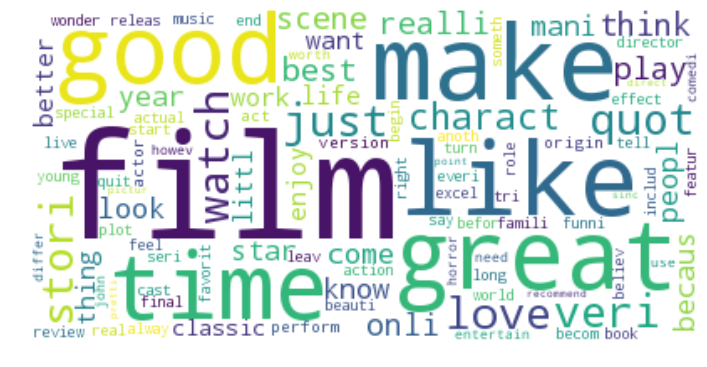

In [624]:
from wordcloud import WordCloud
frequency_dict = dict(freq_unigram_sorted)
wordcloud = WordCloud(background_color = 'white')
wordcloud.generate_from_frequencies(frequencies = frequency_dict)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Looking at the 20 most commonly occuring bi-grams in the text vectors

In [23]:
%%time
vectorizer_bigram = CountVectorizer( max_features = 100, min_df = 15, max_df = 0.5 , ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer )
X_bigram_bow = vectorizer_bigram.fit_transform( data.review_text ).tocsc()

freq_bigram = zip( vectorizer_bigram.get_feature_names(), np.asarray( X_bigram_bow.sum(axis = 0) ).ravel() ) 
freq_bigram_sorted = sorted( list(freq_bigram), key = lambda x: x[1] , reverse = True)
for word_tuple in freq_bigram_sorted[:20]:
    print("Feature: '{}' apeared {} times".format(word_tuple[0],word_tuple[1]) )

Feature: 'thi movi' apeared 474801 times
Feature: 'thi film' apeared 210064 times
Feature: 'great movi' apeared 81166 times
Feature: 'watch thi' apeared 77531 times
Feature: 'love thi' apeared 77460 times
Feature: 'like thi' apeared 48038 times
Feature: 'good movi' apeared 40552 times
Feature: 'veri good' apeared 40516 times
Feature: 'movi make' apeared 35958 times
Feature: 'thi great' apeared 35290 times
Feature: 'movi thi' apeared 34784 times
Feature: 'movi great' apeared 34207 times
Feature: 'make thi' apeared 32120 times
Feature: 'special effect' apeared 30759 times
Feature: 'recommend thi' apeared 29112 times
Feature: 'highli recommend' apeared 28562 times
Feature: 'movi watch' apeared 27335 times
Feature: 'favorit movi' apeared 25636 times
Feature: 'enjoy thi' apeared 25575 times
Feature: 'best movi' apeared 24666 times
CPU times: user 1h 20min 53s, sys: 2min 2s, total: 1h 22min 55s
Wall time: 1h 32min 45s


### Naive Bayes with BOW and TF-IDF Word Embeddings (Multi-Class Classification)
The gensim library has a great pre-processor that tokenizes removes punctuation, non-alphabetic characters,<br>
extra white spaces , stopwords and stems tokens. The purpose of this section is to tokenize and pre-process <br>
review text and fit a naive bayes classifier to see if we can build a model that can with some accuracy <br>
predict the overall rating of a review given the text of the review. For this problem I'll use the follwing <br>
combination of word embeddings with a Naive Bayes classifier. <br>
* Unigrams w/ Bag of Words Embeddings 
* Unigrams w/ Tf-idf Embeddings 
* Bi-grams w/ Bag of Words Embeddings 
* Bi-grams w/ Tf-idf Embeddings

In [24]:
from gensim.parsing.preprocessing import preprocess_documents

def gensim_preprocess(text):
    return preprocess_documents( [text] )[0]

vectorizer_unigram_gensim = CountVectorizer( min_df = 15, max_df = 0.7 , ngram_range = (1,1), tokenizer = gensim_preprocess )
X_unigram_bow_gensim = vectorizer_unigram_gensim.fit_transform( data.review_text )

INFO - 20:08:33: 'pattern' package not found; tag filters are not available for English


Splitting the dataset into train and test split and <br>
defining a piepline that transforms bag of words <br>
to tf-idf embedding and fits a naive bayes classifier on it.

In [25]:
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
warnings.simplefilter(action='ignore', category=FutureWarning)

X_unigram = X_unigram_bow_gensim
y = data.overall.values

X_unigram_train,X_unigram_test,y_train,y_test = train_test_split( X_unigram, y, test_size = 0.3, random_state = 42 )

#Pipeline that takes in a Bag of words embeddings (Sklearn Countvectorizer) and converts them to Tf-idf embeddings 
#and trains a Naive Bayes Classifier on them
tfidf_naiveB_pipeline = Pipeline( steps = [ ( 'tfifd', TfidfTransformer() ) , ( 'nb', MultinomialNB() ) ])

#### Unigram w/ Tf-idf Embeddings

In [26]:
#Cross Validating to find best value for hyperparameter alpha
param_dict_nb_tfidf = dict( nb__alpha = [0.001,0.01,1.0,10] )
cv_nb_tfidf_unigram = GridSearchCV( tfidf_naiveB_pipeline, param_grid = param_dict_nb_tfidf, cv = 5, n_jobs = -1, iid = False )
cv_nb_tfidf_unigram.fit(X_unigram_train,y_train)
print('Best Parameter alpha:', cv_nb_tfidf_unigram.best_params_)
print('Best Validation Score:', cv_nb_tfidf_unigram.best_score_)

Best Parameter alpha: {'nb__alpha': 0.01}
Best Validation Score: 0.6585292838004889


In [28]:
test_score1 = cv_nb_tfidf_unigram.best_estimator_.score(X_unigram_test,y_test)  * 100
print('Accuracy on holdout set: {} %'.format(test_score1) )

Accuracy on holdout set: 65.8454665098834 %


#### Unigram w/ Bag of Words Embeddings

In [29]:
#Cross Validating to find best value for hyperparameter alpha
nb = MultinomialNB()
param_dict_nb_countVect = dict( alpha = [0.001,0.01,1.0,10] )
cv_nb_countVect_unigram = GridSearchCV( nb, param_grid = param_dict_nb_countVect, cv = 5, n_jobs = -1, iid = False )
cv_nb_countVect_unigram.fit(X_unigram_train,y_train)
print('Best Parameter alpha:', cv_nb_countVect_unigram.best_params_)
print('Best Validation Score:', cv_nb_countVect_unigram.best_score_)

Best Parameter alpha: {'alpha': 10}
Best Validation Score: 0.6607936312999021


In [30]:
test_score2 = cv_nb_countVect_unigram.best_estimator_.score(X_unigram_test,y_test)  * 100
print('Accuracy on holdout set: {} %'.format(test_score2) )

Accuracy on holdout set: 65.95476866501599 %


In [31]:
vectorizer_bigram_gensim = CountVectorizer(min_df = 15, max_df = 0.7 , ngram_range = (2,2), tokenizer = gensim_preprocess )
X_bigram_bow_gensim = vectorizer_bigram_gensim.fit_transform( data.review_text )

X_bigram = X_bigram_bow_gensim
X_bigram_train, X_bigram_test, y_train, y_test = train_test_split( X_bigram, y, test_size = 0.3, random_state = 42 )

#### Bi-grams w/ Tf-idf Embeddings

In [32]:
#Cross Validating to find best value for hyperparameter alpha
cv_nb_tfidf_bigram = GridSearchCV( tfidf_naiveB_pipeline, param_grid = param_dict_nb_tfidf, cv = 5, n_jobs = -1, iid = False )
cv_nb_tfidf_bigram.fit(X_bigram_train, y_train)
print('Best Parameter alpha:', cv_nb_tfidf_bigram.best_params_)
print('Best Validation Score:', cv_nb_tfidf_bigram.best_score_)

Best Parameter alpha: {'nb__alpha': 0.01}
Best Validation Score: 0.6710938441025276


In [33]:
test_score3 = cv_nb_tfidf_bigram.best_estimator_.score(X_bigram_test,y_test)  * 100
print('Accuracy on holdout set: {} %'.format(test_score3) )

Accuracy on holdout set: 67.30495301281991 %


#### Bi-grams w/ Bag of Words Embeddings

In [34]:
#Cross Validating to find best value for hyperparameter alpha
cv_nb_countVect_bigram = GridSearchCV( nb, param_grid = param_dict_nb_countVect, cv = 5, n_jobs = -1, iid = False )
cv_nb_countVect_bigram.fit(X_bigram_train,y_train)
print('Best Parameter alpha:', cv_nb_countVect_bigram.best_params_)
print('Best Validation Score:', cv_nb_countVect_bigram.best_score_)

Best Parameter alpha: {'alpha': 10}
Best Validation Score: 0.660837337621294


In [35]:
test_score4 = cv_nb_countVect_bigram.best_estimator_.score(X_bigram_test,y_test)  * 100
print('Accuracy on holdout set: {} %'.format(test_score4) )

Accuracy on holdout set: 66.4595343027128 %


In [36]:
naive_bayes_specs_dict = { 'Specifications':[ 'Unigram Tfidf' , 'Unigram CountVect', 'Bigram Tfidf', 'Bigram CountVect' ] ,
                         'Accuracy_Score':[ test_score1, test_score2, test_score3, test_score4 ] }
naive_bayes_specs_df = pd.DataFrame( naive_bayes_specs_dict )
naive_bayes_specs_df

Specifications  Accuracy_Score
0      Unigram Tfidf       65.845467
1  Unigram CountVect       65.954769
2       Bigram Tfidf       67.304953
3   Bigram CountVect       66.459534

With respect to our model's perfomance on unseen data, bigrams <br>
seems to outperform unigrams for both tfidf and BOW approach, with<br>
tfidf and bigrams having the highest accuracy on unseen data at 67.3%

### Interpretible Machine Learning with Local Surrogate Models approach

The purpose of this section to take the best performing model and see what it has learned from the data <br>
and see how it explains a prediction it makes. For this purpose I will be using the <br>
LIME(Local interpretable model agnostic explanations) library which takes a trained model <br>
and fits a local surrogate model or a simpler interpretable model on the predictions of a <br>
more complicated black box model with respect to the observation of interest in order to explain <br>
why the model made the prediction it made. I will be pulling the following rated reviews <br>
that are not present in the dataset the model was trained on:<br>
* A 5-star review (Clearly Positive)
* A 1-star review (Clearly Negative)
* A 3-star review (somewhere in the middle) 
<br>

I will make predicitons using our model on each of these reviews and use a LIME explainer to visualize why our <br>
model made the prediction it made.

In [130]:
#Importing necessary LIME classes and building a pipeline that vectorizes and makes predictions
#using our best naive bayes model
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
explainer = LimeTextExplainer( class_names = ['1.0', '2.0', '3.0', '4.0', '5.0'] )
exp_pipeline = make_pipeline( vectorizer_unigram_gensim, cv_nb_countVect_unigram.best_estimator_  )

Checking if the title already exists in our data set

In [114]:
"Tom Clancy's Jack Ryan - Season 1" in data.title

False

#### Predicting the overall score for a 5-star review from an unseen title

In [123]:
test_review_5star = "I never read the books so I don't have a bias. This show was good enough that I binged watched them all and dawn is breaking.\
I am tired but it was worth it. This was some compelling story telling. Life is complicated, humanity is complicated, sometimes there are no good \
choices and sometimes good deeds are punished. i felt like the story gave fair play to both sides of the Jihadi vs. the West conflict. The story \
doesn't try to justify what they do or what we do it just shows the motivations and the actions. There are several stories being told that all intertwine, \
but all are important and there didn't seem too be much, if any, filler scences."

print( 'Predicted rating', exp_pipeline.predict( [test_review_5star] ) )
print( 'Probabilities for all classes', exp_pipeline.predict_proba( [test_review_5star] ) )

Predicted rating [5.]
Probabilities for all classes [[5.01912629e-05 3.38803369e-03 9.95378214e-02 3.75561923e-01
  5.21462031e-01]]


In [133]:
exp = explainer.explain_instance(test_review_5star, exp_pipeline.predict_proba, num_features=8, top_labels=2)
exp.show_in_notebook(text=True)

Our model made the correct prediction of score 5 <br>
* The model predicted overall rating of 5 with 52% probability becuase from the training data <br> 
it learned to associate words such as 'tired', 'story', 'Life', 'binged' and 'watched' with 5-star <br>
reviews.
* The next class with the highest probability predicted by our model is 4 with 38% probability because <br>
our model learned to associate words such as 'good', 'filler', 'complicated' and 'fair' with 4-star reviews.

#### Predicting the overall score for a 1-star review from an unseen title

In [131]:
test_review_1star = "When I saw a Tom Clancy series advertised on Amazon Prime months ago, I was so excited, I couldn't wait until it came out.\
I thought, finally, a great show I can watch that won't be full of nudity and sex! But no, my eyeballs were once again assalted against my will in episode 2,\
and when I read the reviews here, I found that it does, indeed, continue. This series is not true Tom Clancy's writing, and I don't even know who to be angry \
with. Did he give Hollywood permission for this? Why does Hollywood think everyone is okay with that? I'm finding more and more that there are so many people \
who are sick and tired of nudity and sex on t.v. every time we try to watch a show. So unbelievably disappointed."

print( 'Predicted rating', exp_pipeline.predict( [test_review_1star] ) )
print( 'Probabilities for all classes', exp_pipeline.predict_proba( [test_review_1star] ) )

Predicted rating [1.]
Probabilities for all classes [[0.85261486 0.01694952 0.0142446  0.00189523 0.11429579]]


In [135]:
exp = explainer.explain_instance(test_review_1star, exp_pipeline.predict_proba, num_features=6, top_labels=2)
exp.show_in_notebook(text=True)

Our model made the correct prediction of score 1 <br>
* The model predicted overall rating of 1 with 85% probability becuase from the training data <br> 
it learned to associate words such as 'advertised', 'unbelievably', 'sex', 'sick' and 'couldn't' with 1-star <br>
reviews.
* The next class with the highest probability predicted by our model is 5 with 11% probability because <br>
our model learned to associate words such as 'great' with 5-star reviews.

#### Predicting the overall score for a 3-star review from an unseen title

In [137]:
test_review_3star = "The show strayed far from Clancy's style. There were many classic tropes and, essentially, \
references to the books, but it felt like the writers of the show were pushed for time. It felt like someone had written an \
outline and the team were too afraid to question major plot points that they left gaping holes. Don't get me wrong, there were many great action \
sequences, witty lines, and suspenseful moments, but in each and every episode, you will reach a point where you ask yourself: 'Did they really \
just do that?' They threw away major parts of Jack's backstory that were key to his identity, and Cathy was never used in any meaningful way. \
It's as if every character besides Jack and Greer are simple one-dimensional puppets. That isn't far from the story-telling style of Clancy, \
but where he makes up for this in adventure and plot, the show was lagging. The show wasn't too unpredictable, and every time there was opportunity \
for chaotic Russian spies or haunting memories from the past it was slow and boring. NOT the way I think Clancy would have told it."

print( 'Predicted rating', exp_pipeline.predict( [test_review_3star] ) )
print( 'Probabilities for all classes', exp_pipeline.predict_proba( [test_review_3star] ) )

Predicted rating [3.]
Probabilities for all classes [[2.06762168e-06 1.61305323e-01 7.61559230e-01 7.58534197e-02
  1.27995972e-03]]


In [139]:
exp = explainer.explain_instance(test_review_3star, exp_pipeline.predict_proba, num_features=8, top_labels=2)
exp.show_in_notebook(text=True)

Our model made the correct prediction of score 3 <br>
* The model predicted overall rating of 3 with 76% probability becuase from the training data <br> 
it learned to associate words such as 'gaping', 'lagging', 'felt', 'far' and 'wasn't' with 3-star <br>
reviews. The model also picked up some noise like 'Clancy', 'Cathy' and 'spies'.
* The next class with the highest probability predicted by our model is 2 with 16% probability because <br>
our model learned to associate words such as 'boring', 'dimensional' and 'gaping' with 2-star reviews.

### Building a Theme-based recommender system with LDA (Latent Dirichlet Allocation) modelling

The purpose of this section is to use LDA topic modelling to identify various topics in all 5-star reviews <br>
and use them to build a theme based recommender system which given a particular user identifies topics in  <br>
all 5-star reviews given by that user and based on those topics finds other titles the user has not seen   <br>
for which the 5-star reviews given by other users contains similar topics and recommends them to that user. <br>
Steps in building the system : <br>
* Use Spacy and Gensim libraries to tokenize, lemmatize and clean all 5-star reviews and convert them to <br>
bag of word embeddings.
* Fit and LDA model on the word embeddings to identify 50 different topics 
* Use the fitted model to recommend titles to users based on the similar topics found in the titles they <br>
gave 5-star reviews and other title's 5-star reviews that they have not seen.

In [3]:
#Importing all necessary modules 
import numpy as np
import os 
import codecs
import en_core_web_sm
from gensim.parsing.preprocessing import strip_non_alphanum, strip_numeric, strip_multiple_whitespaces, \
remove_stopwords, strip_short , split_alphanum, strip_punctuation
from gensim.models import Phrases
from gensim.models.phrases import Phraser 
from gensim.models.word2vec import LineSentence
import itertools as it 
nlp = en_core_web_sm.load()

In [4]:
#Saving all 5-star review documents locally in a text file 
reviews_path = '/Users/sam/DataScience/Datasets/reviews.txt'
np.savetxt( reviews_path, data.review_text[data.overall == 5].values, fmt = '%s'  )

In [5]:
#Generator function that parses and yields each document in the text file  
def gen_line_review(filename):
    with codecs.open( filename, encoding = 'utf-8' ) as file:
        for review in file:
            review = split_alphanum(review)
            yield review
#Generator Function that parses each document in a file and tokenizes and lematizes using Spacy's pipeline and yields the tokenized document
def gen_lemmatized_corpus( filename ):
    for review in nlp.pipe( gen_line_review(filename), batch_size=10000, n_threads = 3 ):
        yield u' '.join( [ token.lemma_ for token in review if not( token.is_space or token.is_punct ) ] )

In [16]:
#Reading each tokenized and lemmatized review document in unigram format and saving it a text file locally 
unigram_review_filepath = '/Users/sam/DataScience/Datasets/unigram_reviews.txt'
with codecs.open(unigram_review_filepath, 'w', encoding = 'utf-8') as file:
    for review in gen_lemmatized_corpus( reviews_path ):
        file.write(review + '\n')
#Reading the file as a gensim object
unigram_reviews = LineSentence( unigram_review_filepath )

In [35]:
for unigram_review in it.islice( unigram_reviews, 960,965 ):
    print( ' '.join(unigram_review) )
    print('')

captivate story with a great message the tension build the realism be strong in place -PRON- watch -PRON- -PRON- to be sure -PRON- be something -PRON- would want to share with friend then share -PRON- with -PRON- watch -PRON- twice in the first week -PRON- own -PRON-

-PRON- have no idea how much hollywood be add to this movie and to what extent the life and time of ben carson be gloss over or idealize what -PRON- do know be the movie be emotional inspiring powerful and very touching this be the story of a young boy who overcome great odd to succeed in life and make a significant contribution to society -PRON- be also a touching story of the love of a mother -PRON- dedication to -PRON- two son and -PRON- strong determination to see -PRON- have the opportunity to be the very good -PRON- could be this be an excellent movie for the entire family and -PRON- strongly recommend -PRON- to all emotional inspiring and almost heroic

everyone need to see this movie proves that no matter what col

All the tokens in each document are properly lemmatized and instead of lemmatizing pronouns, spacy simply replaces it with -PRON- which is of no <br>
consequence to us since we're only interested in the underlying topics.

#### Using gensim's bigram phraser to capture prevelant bigrams in our documents 

In [47]:
#Function that takes in gensim pre-processing functions as arguements and applies them to a tokenized document 
#for clean up
def clean_up(text_list, **kargs):
    text = ' '.join(text_list)
    for func in kargs:
        text = kargs[func](text)
    return text.strip().split()

#Initializing the bigram phraser and it's wrapper 
bigram_model = Phrases(unigram_reviews)
bigram_phraser = Phraser(bigram_model)

bigram_review_filepath = '/Users/sam/DataScience/Datasets/bigram_reviews.txt'
#Parsing each lemmatized document through a clean up function and then passing it through the bigram phraser and saving the results locally
with codecs.open(bigram_review_filepath, 'w', encoding='utf_8') as file:
    for unigram_review in unigram_reviews:
        unigram_review = clean_up( unigram_review, func1 = strip_non_alphanum, 
                                  func2 = strip_numeric, func3 = strip_multiple_whitespaces, func4 = strip_short )
        bigram_review = u' '.join( bigram_phraser[unigram_review] )   
        file.write(bigram_review + '\n')


bigram_reviews = LineSentence(bigram_review_filepath)

In [49]:
for bigram_review in it.islice( bigram_reviews, 960,965 ):
    print( ' '.join(bigram_review) )
    print('')

captivate story with great message the tension_build the realism strong place PRON watch PRON PRON sure PRON something PRON would want share with friend then share PRON with PRON watch PRON twice the first week PRON own PRON

PRON have idea how much hollywood add this movie and what extent the life and time ben_carson gloss_over idealize what PRON know the movie emotional inspiring powerful and very touching this the story young_boy who overcome great odd succeed life and make significant_contribution society PRON also touching story the love mother PRON dedication PRON two son and PRON strong determination see PRON have the opportunity the very good PRON could this excellent movie for the entire_family and PRON strongly_recommend PRON all emotional inspiring and almost heroic

everyone need see this movie proves that matter what color PRON skin financial background may PRON can make something PRON plan share this with PRON child and extended family PRON need more positive role_model l

The bigram phraser was able to capture certain bigrams such as 'tension_build', 'significant_contribution', 'young_boy','entire_family', 'strongly_recommend', <br>
'role_model', 'ben_carson', 'news_program', 'highly_recommend', 'come_across', 'gifted_hands' in our lemmatized documents.

In [73]:
#Further preprocessing the bigram embeddings by removing stopwords, extra space and an extremely prevalent noise word "quot"
preprocessed_reviews_filepath = '/Users/sam/DataScience/Datasets/preprocessed_reviews.txt'
with codecs.open( preprocessed_reviews_filepath, 'w', encoding = 'utf-8' ) as file:
    for bigram_review in bigram_reviews:
        bigram_review = clean_up( bigram_review, func = remove_stopwords )
        preprocessed_review = u' '.join( [ word for word in bigram_review if not( word == 'PRON' or word == '\'s' or word =='quot' ) ] )
        file.write( preprocessed_review + '\n' )

In [74]:
print('Raw Review Text:\n')
for review in it.islice( gen_line_review(reviews_path), 1554, 1555 ):
    print(review)
    
print('-----------\n')
print('Pre-processed:\n')

with codecs.open(preprocessed_reviews_filepath, encoding='utf_8') as file:
    for review in it.islice(file, 1554, 1555):
        print(review)   

Raw Review Text:

While new-comers to Argento should check out AB's release of Deep Red first, this is one of Argento's finest and most accomplished thrillers and certainly more accessible than something like Inferno or Phenomena.  The  plot is deliberately - perhaps deceptively - simple; an American horror  novellist arrives in Italy to promote his new book, but a series of  homicides begin which seem to imitate the murders in his book.  I wouldn't  dream of giving away the ending but trust me - it's worth waiting for.  While it doesn't quite have the visual beauty of Suspiria, or enough twists  or interesting characters to put it in the leages of Deep Red or Bird with  the Crystal Plumage, this film is far from his worst and worth buying if  only for the marvellous presentation - a rare commentary from Argento and  Simonetti and some other guy (a journalist I think), behind the scenes  footage (quite short and lifted from Dario Argento's world of Horror, but a  welcome addition never

Through the above functions and pipelines we were able to severly clean and  prune each review down to important key words ready for topic modelling like the example above. 

In [6]:
#Importing libraries for topic modelling 
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis, pyLDAvis.gensim
import warnings

In [11]:
review_dict_filepath = '/Users/sam/DataScience/Datasets/preprocessed_reviews_dict.txt'
preprocessed_reviews = LineSentence( preprocessed_reviews_filepath )
#Building the vocabulary from our reviews corpora to be used to convert each document to bag of words embedding 
review_dict = Dictionary( preprocessed_reviews )
#Filtering out extreme values from the corpora 
review_dict.filter_extremes( no_below = 15, no_above = 0.4 )
review_dict.compactify()
#Saving the dictionary locally 
review_dict.save( review_dict_filepath )

In [12]:
#Generator function that parses a file containing documents and converts each document to a 
#bag of words embedding 
def generate_bow(file_path):
    for review in LineSentence(file_path):
        yield review_dict.doc2bow(review)

review_dict = Dictionary.load( review_dict_filepath )

reviews_bow_filepath = '/Users/sam/DataScience/Datasets/reviews_bow.txt'

MmCorpus.serialize( reviews_bow_filepath, generate_bow( preprocessed_reviews_filepath ) )

In [8]:
bow_corpus = MmCorpus(reviews_bow_filepath)

In [9]:
#Fitting the LDA model on our bag of word embeddings 
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda = LdaMulticore( bow_corpus, num_topics = 50, id2word = review_dict, workers = 3 )

In [177]:
#Visualizing each topic and it's most commonly occuring frequencies 
for idx, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.026*"time" + 0.026*"excellent" + 0.022*"acting" + 0.021*"story" + 0.021*"western" + 0.021*"watch" + 0.019*"actor" + 0.017*"classic" + 0.015*"favorite" + 0.014*"cast"

Topic: 1 
Words: 0.030*"life" + 0.013*"man" + 0.010*"son" + 0.010*"live" + 0.008*"father" + 0.008*"wife" + 0.008*"come" + 0.008*"love" + 0.008*"woman" + 0.008*"leave"

Topic: 2 
Words: 0.066*"book" + 0.033*"read" + 0.019*"story" + 0.017*"novel" + 0.014*"like" + 0.012*"version" + 0.012*"adaptation" + 0.011*"character" + 0.009*"think" + 0.009*"watch"

Topic: 3 
Words: 0.031*"horror" + 0.013*"scary" + 0.013*"like" + 0.011*"zombie" + 0.011*"vampire" + 0.009*"watch" + 0.009*"dead" + 0.009*"time" + 0.008*"halloween" + 0.008*"iron_man"

Topic: 4 
Words: 0.058*"match" + 0.012*"scott" + 0.012*"like" + 0.012*"win" + 0.011*"time" + 0.009*"chocolat" + 0.007*"michael_caine" + 0.007*"actor" + 0.006*"football" + 0.006*"george"

Topic: 5 
Words: 0.012*"action" + 0.007*"violence" + 0.006*"like" + 0.006*"way" + 0.005*"sc

Some of the themes identified by our model are very easy to label such as topic 5 which contains frequencies such as "action","violence", "man", "crimimal", "crime" and is clearly about action/crime movies <br>
and topic 10 that contains frequencies like "bond", "murder", "mystery", "edge", "seat" is clearly about spy/thriller/mystery movies while for some topics such as topic 13 which contains frequencies such as <br>
"like", "know", "people", "think", "thing", "happen", it is not so clear what they are about.

#### Visualizing the topics and the distances between them using the pyLDAvis library

In [12]:
LDAvis_prep = pyLDAvis.gensim.prepare( lda, bow_corpus, review_dict )
pyLDAvis.display( LDAvis_prep )

/Users/sam/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In the above visualization each topic is represented by a bubble in the 2 principal component axes and the distance between any <br>
two bubbles is represented by the similarity of of those topics measured using the word frequencies in each topic. So for <br>
example if two bubbles are very close to each other, our model has identified those topics to be similar, if two bubbles are so <br>
close that they intersect then that means they share some common word frequencies and if two bubbles are far apart , <br>
they don't share common word frequencies and are not very similar to each other. The size of each bubble represents the <br>
proportion of the most relevent terms for the entire corpora found in that particular topic. <br>
<br>
Looking at the graph we see that on the graph topic number 22 and 33 are very fart apart from each other which means <br>
our LDA model was able to learn that topic 22 with themes such as "love", "romance", "romantic", "woman" is further apart or not <br>
similar to topic 33 with themes such as "comic_book", "superhero", "villain", "batman", "spiderman". 

#### Building the recommender system 

In [197]:
#Function that works as a pipeline in applying all the steps seen above to a raw review to convert it 
#to a clean bag of words embedding 
def _get_topics(review):
    
    spacy_tokenized_review = nlp( review )
    
    unigram_lemmatized_review = [  token.lemma_ for token in spacy_tokenized_review if not( token.is_space or token.is_punct ) ] 
    
    cleaned_lemmatized_unigram_review = clean_up( unigram_lemmatized_review, func1 = strip_non_alphanum, 
                                  func2 = strip_numeric, func3 = strip_multiple_whitespaces, func4 = strip_short )
    
    bigram_review =  bigram_phraser[cleaned_lemmatized_unigram_review]
    
    cleaned_bigram_review = clean_up( bigram_review, func = remove_stopwords )
    
    pre_processed_review = [ word for word in cleaned_bigram_review if not( word == 'PRON' or word == '\'s' or word =='quot' ) ]
    
    bow_review = review_dict.doc2bow(  pre_processed_review  )
    
    lda_review = sorted( lda[bow_review], key = lambda t: t[1], reverse = True)
    
    return lda_review

#Displays topics identified in a given review 
def display_topics(review, min_topic_freq = 0.1):
    for topic_num, freq in _get_topics(review):
        if freq < min_topic_freq:
            break
        print('Topic Number: {:<10} {:.3f}'.format( topic_num, freq ) )

In [68]:
five_star_review_1 = data[ data.overall == 5 ].review_text[89456]
five_star_review_1

'When i started watching the mad max movies i started with whichever one i found at the store and so i wound up going backward, starting with beyond thunder dome.  I was hooked in right then and there and i knew there was no way any other one would compare. I was wrong.  I loved Road Warrior the best. It brought something new to the plate.  I think it had a lot to do with the relationship between max and the feral kid. I love an action movie with soul. I think thats why i always loved Terminator 2 so much.  Road Warrior was like that with me.  The Mad Max movies were priceless. I hope they never re make them. . i went into this trilogy so backward but this is my favorite'

In [198]:
display_topics(five_star_review_1)

Topic Number: 25         0.371
Topic Number: 42         0.355
Topic Number: 1          0.183


In [195]:
five_star_review_2 = data[ data.overall == 5 ].review_text[237578]
five_star_review_2

"I've no idea what I could say which many others likely already have, but, what the heck...  Tom Hanks and Darryl Hannah star in this unlikely love affair between a boy and his fish...uh...Mermaid.  John Candy co-stars in a bit role, as was many of his earlier films, as a party headed, drunk, womanizing leech of a brother with the responsibility and conscience of an ingrown toenail.  About as helpful as one too.  The plot thickens as, all grown-up Hank's, Alan must head the company alone; while his brother squanders their livelihood and Alan himself pines away for the spark of love in his heart who he cannot recall and tries to put it off on any current partner.  Until the mysterious Madison shows up and rekindles that spark into a blazing inferno!  Romance, comedy and drama ensues there after. . SPLASH!"

In [199]:
display_topics(five_star_review_2)

Topic Number: 14         0.320
Topic Number: 44         0.190
Topic Number: 1          0.115


In [227]:
from collections import Counter
#Function that pre-processed and extracts all the topics in a given raw review 
def _extract_topics(review):
    return [ t[0] for t in _get_topics(review) if t[1] > 0.1 ]
#Given a user, parses all the reviews given by that user and returns the 3 most prevalent topics in their reviews
def _get_user_topics(user_id):
    topics = []
    user_reviews = data[(data.reviewerID == user_id) & (data.overall == 5) ].review_text
    for review in user_reviews:
        topics.append( _extract_topics(review) )
    counter = Counter( [ topic_nums for inner_list in topics for topic_nums in inner_list ] )
    return [ t[0] for t in counter.most_common(3) ]
#Given a user returns a list of titles based on all the favorable reviews left by the user 
def recommend_titles(user_id):
    titles = []
    target_topics = _get_user_topics(user_id)
    print('Target Topics:' , target_topics)
    for index , row in data[ data.overall == 5 ].iterrows():
        topics = _extract_topics(row.review_text)
        for topic in topics:
            if topic in target_topics and row.title not in titles:
                titles.append( row.title )
    return titles     

In [228]:
user = 'A3QOPWF1LQCR6L'
titles = recommend_titles(user)
print('Total titles found:', len(titles))

Target Topics: [42, 18, 25]
Total titles found: 11030


In [232]:
print('Titles rated highly by this user:\n')
print( data[ (data.overall == 5) & (data.reviewerID == user) ].title )

Titles rated highly by this user:

5006              Air Force One
14633          One Fine Morning
454000    You've Got Mail [VHS]
489576    Black Hawk Down [VHS]
Name: title, dtype: object


In [314]:
print('Subset of titles recommended by our LDA based recommender system:\n')
print(titles[264])
print(titles[161])
print(titles[6176])
print(titles[9156])

Subset of titles recommended by our LDA based recommender system:

The Way We Were - 25th Anniversary Edition [VHS]
The Last Action Hero [VHS]
Detonator [VHS]
Meet the Parents [VHS]


The theme based recommender system was succesfuly able to parse, pre-process , idetify themes and recommend titles <br>
based on favorable reviews given a user. However the model lacked certain finesse and fine tuning and also ended <br>
up being computationally ineffcient and would not be optimal to use when recommendations for multiple users <br>
have to be calculated and returned in real time. <br>
As a result a different approach altogether would be needed to build a more effcient recommender system that supports <br>
faster computation and more fine tuned results. To achieve that I will use a collaborative filtering based recommendation <br>
system using overall review scores in the next section.

### Collaborative Filtering Recommendation System with Matrix Factorization (SVD)
For this recommendation system we're not going to need the reviews but simply the overall ratings given by each user to <br>
different titles. I'm going to use a matrix where the rows are each unique title and the columns are each unique user and then <br>
apply singular value decomposition to reduce dimensionality by extracting the latent factors which would help us better model the<br>
similarity between users and items and create a recommendation system that is computationally efficient and faster once the matrix <br>
has been decomposed to it's latent space with n dimensions.<br>
This approach towards building a recommendation system is pretty popular and is called a model based Collabortaive filtering system.<br>
In layman's term the idea behind this model is that the preferences and attitudes of a user can be determined by a small number of <br>
factors and we'll decompose our utility matrix into these factors and then model the similarity between these titles based on the users <br>
who rated them and recommend them to other users with similar preferences.

In [315]:
#Extracting the features needed to build the utility matrix 
user_rating_title_df = data[['reviewerID', 'title', 'overall']]

In [326]:
user_rating_title_df.head()

reviewerID         title  overall
0   AJSYTZQVJJOYW  Joseph [VHS]      4.0
1  A1QNGKV688Q8TE  Joseph [VHS]      5.0
2  A36311XF4O81IK  Joseph [VHS]      5.0
3   AQ8DU6XVA3USJ  Joseph [VHS]      5.0
4  A1ZLFCUF4XX7RZ  Joseph [VHS]      5.0

In [321]:
print( 'Total unique movie titles in our dataset: {}'\
      .format( len(user_rating_title_df.title.unique() ) ) )

print('Total unique reviewers in our dataset: {}'\
     .format( len( user_rating_title_df.reviewerID.unique() ) ) )

print('Total reviews in our dataset: {}'.format( len(user_rating_title_df) ) )

Total unique movie titles in our dataset: 13074
Total unique reviewers in our dataset: 101076
Total reviews in our dataset: 648300


In [329]:
#Pivoting the extracted dataframe to build the utility matrix and transposing it to get shape we want 
utility_matrix = user_rating_title_df.pivot_table( values = 'overall', columns = 'title', index = 'reviewerID' , fill_value = 0 )
utility_matrix = utility_matrix.T
utility_matrix.head()

reviewerID                                          A00295401U6S2UG3RAQSZ  \
title                                                                       
&quot;Ay, Carmela!&quot; [VHS]                                        0.0   
&quot;IVideo&quot; French                                             0.0   
&quot;Sailor Moon S - Birthday Blues (Vol. 4, T...                    0.0   
&quot;Violent Cop (&quot;&quot;Violent&quot;&qu...                    0.0   
'night, Mother [VHS]                                                  0.0   

reviewerID                                          A00348066Q1WEW5BMESN  \
title                                                                      
&quot;Ay, Carmela!&quot; [VHS]                                       0.0   
&quot;IVideo&quot; French                                            0.0   
&quot;Sailor Moon S - Birthday Blues (Vol. 4, T...                   0.0   
&quot;Violent Cop (&quot;&quot;Violent&quot;&qu...                   0.0   
'night, Mother [VHS]                                                 0.0   

reviewerID                                          A0040548BPHKXMHH3NTI  \
title                                                                      
&quot;Ay, Carmela!&quot; [VHS]                                       0.0   
&quot;IVideo&quot; French                                            0.0   
&quot;Sailor Moon S - Birthday Blues (Vol. 4, T...                   0.0   
&quot;Violent Cop (&quot;&quot;Violent&quot;&qu...                   0.0   
'night, Mother [VHS]                                                 0.0   

reviewerID                                          A00438023NNXSDBGXK56L  \
title                                                                       
&quot;Ay, Carmela!&quot; [VHS]                                        0.0   
&quot;IVideo&quot; French                                             0.0   
&quot;Sailor Moon S - Birthday Blues (Vol. 4, T...                    0.0   
&quot;Violent Cop (&quot;&quot;Violent&quot;&qu...                    0.0   
'night, Mother [VHS]                                                  0.0   

reviewerID                                          A00503563AVX48TRHJGR6  \
title                                                                       
&quot;Ay, Carmela!&quot; [VHS]                                        0.0   
&quot;IVideo&quot; French                                             0.0   
&quot;Sailor Moon S - Birthday Blues (Vol. 4, T...                    0.0   
&quot;Violent Cop (&quot;&quot;Violent&quot;&qu...                    0.0   
'night, Mother [VHS]                                                  0.0   

reviewerID                                          A0056274FAHZQC4N2ZN8  \
title                                                                      
&quot;Ay, Carmela!&quot; [VHS]                                       0.0   
&quot;IVideo&quot; French                                            0.0   
&quot;Sailor Moon S - Birthday Blues (Vol. 4, T...                   0.0   
&quot;Violent Cop (&quot;&quot;Violent&quot;&qu...                   0.0   
'night, Mother [VHS]                                                 0.0   

reviewerID                                          A0057670FKKO20E9X6XL  \
title                                                                      
&quot;Ay, Carmela!&quot; [VHS]                                       0.0   
&quot;IVideo&quot; French                                            0.0   
&quot;Sailor Moon S - Birthday Blues (Vol. 4, T...                   0.0   
&quot;Violent Cop (&quot;&quot;Violent&quot;&qu...                   0.0   
'night, Mother [VHS]                                                 0.0   

reviewerID                                          A00700212KB3K0MVESPIY  \
title                                                                       
&quot;Ay, Carmela!&quot; [VHS]                                        0.0   
&quot;IVideo&quot

In [362]:
from sklearn.decomposition import TruncatedSVD
#Initializing the svd class to decompose our utility matrix to 10000 most important latent factors 
svd = TruncatedSVD(n_components = 10000, random_state = 42)
#Fitting it on our data
t_matrix = svd.fit_transform( utility_matrix )
#Calculating the correlation matrix of our decomposed matrix 
corr_mat = np.corrcoef( t_matrix )

In [366]:
#Saving the decomposed and correlation matrix to file 
corr_svd_mat_filepath = '/Users/sam/DataScience/Datasets/corr_svd_mat_reviews'
np.save( corr_svd_mat_filepath, corr_mat )
svd_mat_filepath = '/Users/sam/DataScience/Datasets/svd_mat_reviews'
np.save( svd_mat_filepath, t_matrix )

In [559]:
movie_names =  utility_matrix.T.columns 
movie_names_list = list( movie_names )
#Function that takes in a user id and returns a list containing the top 5 recommendations for each movie
#the user rated 5 stars based on the calculated corr matrix 
def recommend_titles_cf(user_id):
    
    recommended = []
    user_movies = set( data[ (data.reviewerID == user) & (data.overall == 5) ].title )
    
    for w_title in user_movies:
        w_title_high_corr_indices =  np.argsort( corr_mat[ movie_names_list.index(w_title) ] )
        
        for title_index in w_title_high_corr_indices[::-1][1:6]:
            if movie_names[title_index] not in recommended:
                recommended.append( movie_names[title_index] )
    
    return recommended 

In [569]:
print('Titles rated highly by this user:\n')
for movie in list( ( data[ (data.overall == 5) & (data.reviewerID == user) ].title ) ):
        print(movie)
print()
print()
print()
print('Titles recommneded by our collaborative filtering system:\n')
for movie in recommend_titles_cf('A3QOPWF1LQCR6L'):
    print(movie)

Titles rated highly by this user:

Air Force One
One Fine Morning
You've Got Mail [VHS]
Black Hawk Down [VHS]



Titles recommneded by our collaborative filtering system:

Entrapment [VHS]
Desperate Measures
Ransom [VHS]
The Bone Collector
The Confession
Saving Private Ryan [VHS]
Pearl Harbor (Two-Videotape Set) (60th Anniversay Commemorative Edition) [VHS]
Training Day [VHS]
The Bourne Identity (Widescreen Collector's Edition)
Minority Report (Widescreen Two-Disc Special Edition)
Sleepless in Seattle
While You Were Sleeping [VHS]
When Harry Met Sally... [VHS]
French Kiss [VHS]
In Love and War (1996) [VHS]
The Fugitive
Patriot Games [VHS]
Armageddon [VHS]
The Rock [VHS]
Die Hard 2 [VHS]


* The user rated 'Air Force One' highly which is an action/thriller/spy movie  and we see the model recommended other such <br>
movies such as 'The Bone Collector', 'The Bourne Identity', 'Training Day' and another famous Harrison Ford movie 'The Patriot Games' 
* The user rated 'Black Hawk Down' highly which is a war/action movie and we see the model recommended other such movies <br>
like 'Pearl Harbor' and 'Saving Private Ryan'.
* The user rated 'One Fine Morning' and 'You've Got Mail' which are drama movies and we see the model recommended other such movies <br>
such as 'Sleepless in Seattle', 'While you were sleeping', 'French Kiss'. 

<br>For a very simple collaborative filtering system out model has done a good job of recommending movies to the given user.